# Random Acts of Pizza - Baseline Model & EDA
## Authors: Ben Arnoldy, Mary Boardman, Zach Merritt, and Kevin Gifford
#### Kaggle Competition Description:
In machine learning, it is often said there are no free lunches. How wrong we were.

This competition contains a dataset with 5671 textual requests for pizza from the Reddit community Random Acts of Pizza together with their outcome (successful/unsuccessful) and meta-data. Participants must create an algorithm capable of predicting which requests will garner a cheesy (but sincere!) act of kindness.

"I'll write a poem, sing a song, do a dance, play an instrument, whatever! I just want a pizza," says one hopeful poster. What about making an algorithm?

Kaggle is hosting this competition for the machine learning community to use for fun and practice. This data was collected and graciously shared by Althoff et al. (Buy them a pizza -- data collection is a thankless and tedious job!) We encourage participants to explore their accompanying paper and ask that you cite the following reference in any publications that result from your work:

Tim Althoff, Cristian Danescu-Niculescu-Mizil, Dan Jurafsky. How to Ask for a Favor: A Case Study on the Success of Altruistic Requests, Proceedings of ICWSM, 2014.
_______________________________________________________________________________________________

## Notebook Title: EDA & Model Baseline
#### Purpose: Load the 'Random Acts of Pizza' train and test data. Conduct an exploratory data analysis to gain an understanding of the data. Create a baseline Logisitic Regression model using non-text (numeric) fields only. 

## I. Load Data and Modules, Process Data

### A. Load Data and Modules

In [34]:
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

#ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn import svm
from sklearn.svm import SVC
from scipy.sparse import coo_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.ensemble import GradientBoostingClassifier

#NLP
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
#source: https://www.kaggle.com/alvations/basic-nlp-with-nltk
#nltk.download('stopwords')
#nltk.download('brown')
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')


%matplotlib inline
plt.style.use('bmh')

In [35]:
#1. Train Data
with open('../data/train.json') as fin:
    trainjson = json.load(fin)
train = pd.io.json.json_normalize(trainjson)
#2. Test Data
with open('../data/test.json') as fin:
    testjson = json.load(fin)
test = pd.io.json.json_normalize(testjson)

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (4040, 32)
Test Shape: (1631, 17)


### B1. Find any missing values

In [3]:
train.isnull().sum()

giver_username_if_known                                    0
number_of_downvotes_of_request_at_retrieval                0
number_of_upvotes_of_request_at_retrieval                  0
post_was_edited                                            0
request_id                                                 0
request_number_of_comments_at_retrieval                    0
request_text                                               0
request_text_edit_aware                                    0
request_title                                              0
requester_account_age_in_days_at_request                   0
requester_account_age_in_days_at_retrieval                 0
requester_days_since_first_post_on_raop_at_request         0
requester_days_since_first_post_on_raop_at_retrieval       0
requester_number_of_comments_at_request                    0
requester_number_of_comments_at_retrieval                  0
requester_number_of_comments_in_raop_at_request            0
requester_number_of_comm

No missing data except in column "requester_user_flair." We see in the next section that this isn't a column in the test data, so we may just elect to not use it to train the model.

### B2. Identify common columns between test and train

In [4]:
print("Common columns in train and test:")
print(train.columns[train.columns.isin(test.columns)])
print("----")
print("Columns in train but NOT test:")
print(train.columns[~train.columns.isin(test.columns)])

Common columns in train and test:
Index(['giver_username_if_known', 'request_id', 'request_text_edit_aware',
       'request_title', 'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc'],
      dtype='object')
----
Columns in train but NOT test:
Index(['number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_number_of_comments_at_retrieval', 'request_text',
       '

As can be seen above, there is a series of columns in the training data only. These columns reflect data about the post (e.g., the #of upvotes) at the time this Reddit data was retrieved. We use certain supervised and unsupversied techniques to derive value from this data (even though that information is not provided on the data set we will be predicting).

### C. Create training data, labels, and special 'in training only' data

In [36]:
train_labels_master = train[['requester_received_pizza']]
train_data_master = train[test.columns & train.columns]
train_only_data_master = train[train.columns[~train.columns.isin(test.columns)]].drop(['requester_received_pizza'], axis = 1)

### D. Set column types and profile

In [37]:
train_data_master = train_data_master.assign(
    unix_timestamp_of_request = pd.to_datetime(
        train_data_master.unix_timestamp_of_request, unit = "s"),
    unix_timestamp_of_request_utc = pd.to_datetime(
        train_data_master.unix_timestamp_of_request_utc, unit = "s"))

In [38]:
train_data_master.describe()
train_data_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 17 columns):
giver_username_if_known                               4040 non-null object
request_id                                            4040 non-null object
request_text_edit_aware                               4040 non-null object
request_title                                         4040 non-null object
requester_account_age_in_days_at_request              4040 non-null float64
requester_days_since_first_post_on_raop_at_request    4040 non-null float64
requester_number_of_comments_at_request               4040 non-null int64
requester_number_of_comments_in_raop_at_request       4040 non-null int64
requester_number_of_posts_at_request                  4040 non-null int64
requester_number_of_posts_on_raop_at_request          4040 non-null int64
requester_number_of_subreddits_at_request             4040 non-null int64
requester_subreddits_at_request                       4040 non-null obj

## II. EDA

### A. Print Example Posts

In [6]:
for a in [False, True]:
    for b in range(2):
        print("requester_received_pizza ==",a)
        print("------")
        i = train[train['requester_received_pizza']==a].index[b]
        print('UID:\t', trainjson[i]['request_id'], '\n')
        print('Title:\t', trainjson[i]['request_title'], '\n')
        print('Text:\t', trainjson[i]['request_text_edit_aware'], '\n')
        print('Tag:\t', trainjson[i]['requester_received_pizza'], end='\n')
        print("______________________________________")
    print("______________________________________")

requester_received_pizza == False
------
UID:	 t3_l25d7 

Title:	 Request Colorado Springs Help Us Please 

Text:	 Hi I am in need of food for my 4 children we are a military family that has really hit hard times and we have exahusted all means of help just to be able to feed my family and make it through another night is all i ask i know our blessing is coming so whatever u can find in your heart to give is greatly appreciated 

Tag:	 False
______________________________________
requester_received_pizza == False
------
UID:	 t3_rcb83 

Title:	 [Request] California, No cash and I could use some dinner 

Text:	 I spent the last money I had on gas today. Im broke until next Thursday :( 

Tag:	 False
______________________________________
______________________________________
requester_received_pizza == True
------
UID:	 t3_14gmeb 

Title:	 [REQUEST] I'll give a two week xbox live code for a slice of pie! 

Text:	 Feeling under the weather so I called out off work today! I hate requestin

### B. Visualize Dependent Variable: Did the requester recieve a pizza?

C:\Users\zmerritt\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


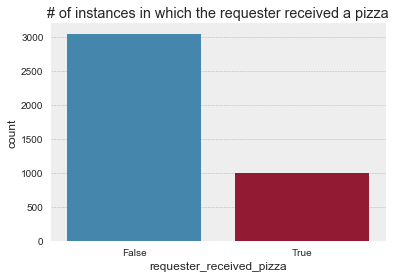

In [39]:
(sns.countplot(x = train_labels_master.requester_received_pizza).
set_title("# of instances in which the requester received a pizza"));

### C. Visualize All Numeric Fields

#### 1. In training and test data

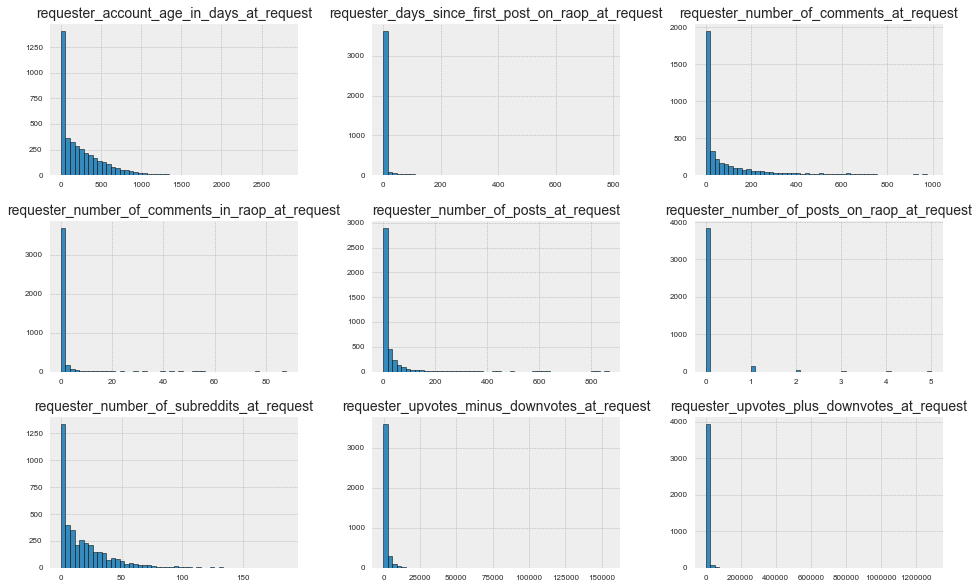

In [10]:
df_num = (train_data_master.select_dtypes(include = ['float64', 'int64']))
df_num.shape

fig = df_num.hist(figsize=(16, 10), bins=50, xlabelsize=8, ylabelsize=8, ec="k")
fig = [x.title.set_size(14) for x in fig.ravel()]
fig;

#### 2. In training data only

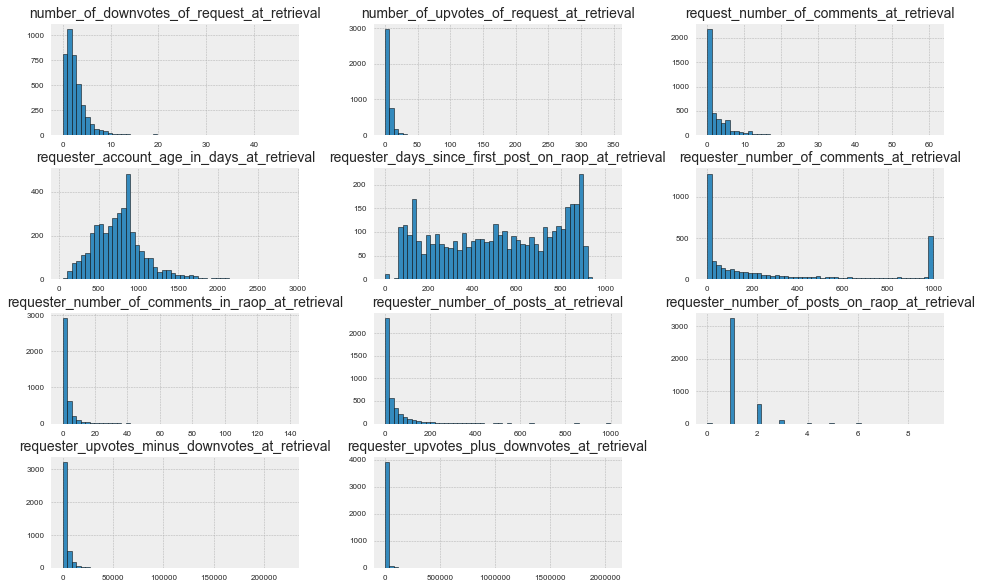

In [11]:
df_num = (train_only_data_master) #all columns are numeric
df_num.shape

fig = df_num.hist(figsize=(16, 10), bins=50, xlabelsize=8, ylabelsize=8, ec="k")
fig = [x.title.set_size(14) for x in fig.ravel()]
fig;

### Correlation among columns and granted request

In [33]:
train_only_data_master.shape
train_labels_master.shape
data = train_only_data_master
data['labels'] = train_labels_master

for i in range(train_labels_master.columns.shape[0]):
    
    col = data.columns[i]
    print(col)
    print("-- ", data['labels'].corr(pd.to_numeric(data[col], errors='coerce')))


number_of_downvotes_of_request_at_retrieval
--  0.0268158596548
number_of_upvotes_of_request_at_retrieval
--  0.102137843061
post_was_edited
--  0.0494800239846
request_number_of_comments_at_retrieval
--  0.289152564572
request_text
--  nan
requester_account_age_in_days_at_retrieval
--  0.12091946638
requester_days_since_first_post_on_raop_at_retrieval
--  0.129282828528
requester_number_of_comments_at_retrieval
--  0.105216501921
requester_number_of_comments_in_raop_at_retrieval
--  0.274252963194
requester_number_of_posts_at_retrieval
--  0.048352697795
requester_number_of_posts_on_raop_at_retrieval
--  0.460636657681
requester_upvotes_minus_downvotes_at_retrieval
--  0.0777284396881
requester_upvotes_plus_downvotes_at_retrieval
--  0.0459938994671
requester_user_flair
--  nan
labels
--  1.0


In [30]:
x

array([[  0.00000000e+00,   1.00000000e+00,   0.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  2.00000000e+00,   5.00000000e+00,   0.00000000e+00, ...,
          2.00000000e+00,   4.25800000e+03,   1.11680000e+04],
       [  0.00000000e+00,   3.00000000e+00,   0.00000000e+00, ...,
          1.00000000e+00,   3.00000000e+00,   3.00000000e+00],
       ..., 
       [  4.00000000e+00,   1.00000000e+01,   2.00000000e+00, ...,
          1.00000000e+00,   1.32700000e+03,   5.76100000e+03],
       [  2.00000000e+00,   7.00000000e+00,   4.00000000e+00, ...,
          1.00000000e+00,   1.30000000e+01,   4.10000000e+01],
       [  0.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   3.61600000e+03,   9.18600000e+03]])

### D. Visualize requests and granted requests over time

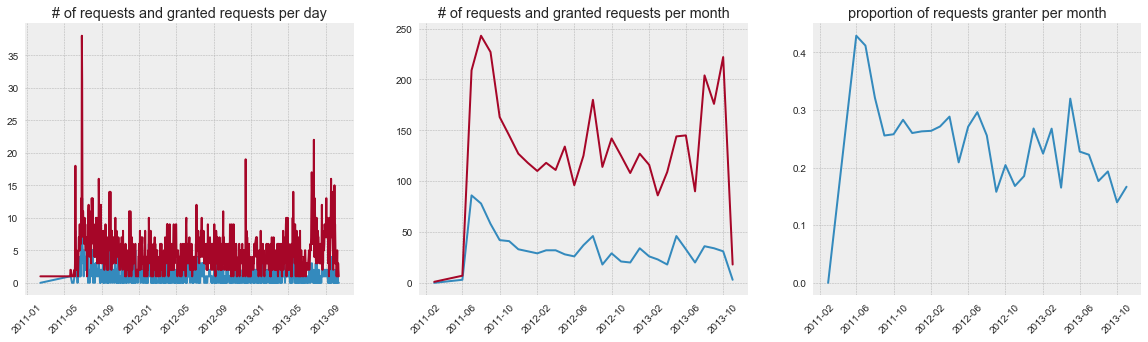

In [12]:
#Data set up
ts = pd.DataFrame({'granted requests':train_labels_master.requester_received_pizza.tolist(),
                  'requests':[1] * train_labels_master.shape[0]},
                index = train_data_master.unix_timestamp_of_request.dt.date.tolist())
ts = ts.groupby(ts.index).sum()
ts_month = pd.DataFrame({'granted requests':train_labels_master.requester_received_pizza.tolist(),
                  'requests':[1] * train_labels_master.shape[0]},
                index = (train_data_master.unix_timestamp_of_request.dt.date + pd.offsets.MonthBegin(0)).tolist())
ts_month = ts_month.groupby(ts_month.index).sum()

#Plots
#1. By day
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.plot(ts)
plt.title("# of requests and granted requests per day")
plt.xticks(rotation=45)
#2. By Month
plt.subplot(1,3,2)
plt.plot(ts_month)
plt.title("# of requests and granted requests per month")
plt.xticks(rotation=45)
#3. By Month (prop)
plt.subplot(1,3,3)
plt.plot(ts_month.assign(prop_granted = ts_month['granted requests'] / ts_month['requests'])['prop_granted'])
plt.title("proportion of requests granter per month")
plt.xticks(rotation=45)
plt.show()

As seen above, there was a spike of requests in the in mid 2011 and in the end of 2013. However, besides those periods, the number of requests has remained relatively stagnant at 100 - 150 per month. 

Additionally, while there is a slight downward trend to the proportion of requests granted, the proportion has also remained relatively stagnant at 15% to 30% of requests being granted per month.

### E. Create Word Clouds of Granted and Ungranted Requests

In [13]:
granted = train_data_master[train_labels_master['requester_received_pizza']==True]
#print(granted.shape)
ungranted = train_data_master[train_labels_master['requester_received_pizza']==False]
#print(ungranted.shape)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(granted['request_text_edit_aware']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Granted Requests",fontsize=26, fontweight='bold', style='italic')
plt.show()

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(ungranted['request_text_edit_aware']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Ungranted Requests",fontsize=26, fontweight='bold', style='italic')
plt.show()

NameError: name 'STOPWORDS' is not defined

# III. Split train, test, and dev sets

In [67]:
#Apply train_test_split twice to get train, test, and dev set
x_train, x_test, y_train, y_test = train_test_split(
    train_data_master, 
    train_labels_master.values.ravel(), test_size=0.2, random_state=0)

x_test, x_dev, y_test, y_dev = train_test_split(
    x_test, 
    y_test, test_size=0.2, random_state=0)
print(x_train.shape)
print(x_test.shape)
print(x_dev.shape)
print(y_train.shape)
print(y_test.shape)
print(y_dev.shape)

(3232, 17)
(646, 17)
(162, 17)
(3232,)
(646,)
(162,)


# IV. Define Modelling Functions

In [49]:
def model_report(title, y_test, predictions):

    """
    Output: Classification report, confusion matrix, and ROC curve
    """
    print(title)
    print("---------")
    print(classification_report(y_test, predictions))

    cm = metrics.confusion_matrix(y_test, predictions)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy: {0}'.format(round(metrics.accuracy_score(y_test, predictions),2))
    plt.title(all_sample_title, size = 15)
    plt.show()
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# V. Baseline Models

### A. Baseline Model 1: Logistic Regression (on common numeric fields only)

Logistic Regression (using only common numeric fields)
---------
             precision    recall  f1-score   support

      False       0.75      0.99      0.86       478
       True       0.72      0.08      0.14       168

avg / total       0.75      0.75      0.67       646



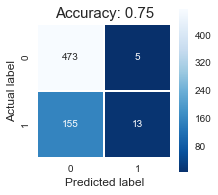

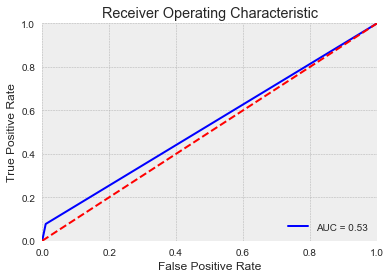

In [68]:
#Normalize all fields (numeric)
standard_scaler = preprocessing.StandardScaler()
x_trainLR = standard_scaler.fit_transform(
    x_train.select_dtypes(include = ['float64', 'int64','datetime64[ns]']).apply(pd.to_numeric).values)

#Apply to test set
x_testLR = standard_scaler.transform(
    x_test.select_dtypes(include = ['float64', 'int64','datetime64[ns]']).apply(pd.to_numeric).values)

#Train Model
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
logisticRegr.fit(x_trainLR, y_train)
predictions = logisticRegr.predict(x_testLR)

#Output model report
model_report("Logistic Regression (using only common numeric fields)",y_test, predictions)

### B. Baseline Model 2: Naive Bayes (Text field only)

Naive Bayes (using text field only)
---------
             precision    recall  f1-score   support

      False       0.75      0.85      0.80       477
       True       0.34      0.22      0.27       169

avg / total       0.65      0.68      0.66       646



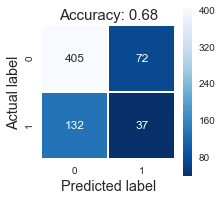

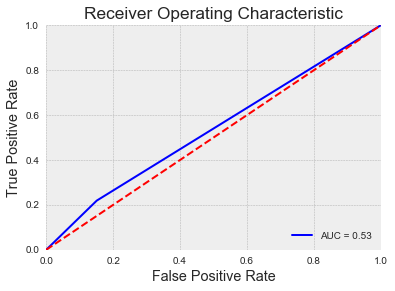

In [17]:
#Create Sparse matrix of words
count_vect = CountVectorizer()
#Apply to train and test data

x_trainNB = count_vect.fit_transform(x_train['request_text_edit_aware'])
x_testNB = count_vect.transform(x_test['request_text_edit_aware'])

#Train Model
# all parameters not specified are set to their defaults
nb = BernoulliNB()
nb.fit(x_trainNB, y_train)
predictions = nb.predict(x_testNB)

model_report("Naive Bayes (using text field only)",y_test, predictions)

# VII. Define Clean Text Field Functions

In [40]:
stopwords_en = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def word_tokenize2(text):
    return(text.split())
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize2(text))]

def text_standardize(s):
    s =  re.compile("[^\w']|_").sub(" ",s.lower())
    s = re.sub(' +',' ', s)
    return s

def word_clean(data):
    """
    Remove stop words.
    Apply NLP to make walk, walking, walked all the same word.
    Only keep nouns and adjective.
    Remove words that I think are messing things up (e.g, pizza, reddit)
    """
    clean_data = []
    for i in range(len(data)):
        querywords = lemmatize_sent(data[i])
        resultwords  = [text_standardize(word) for word in querywords if word.lower() 
                        not in stopwords_en 
                        and not word.isdigit()]
        tags = nltk.pos_tag(resultwords)
        resultwords_nouns = [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or 
                                                           pos == 'NNS' or pos == 'NNPS' or
                                                           pos == 'JJ' or pos == "JJR" or
                                                           pos == "JJS") or (word == "please")]
        result = ' '.join(resultwords_nouns)
        clean_data.append(result)
    return clean_data

In [41]:
test = ["PLEASE give me pizza   I am dying for a slice thank you"]
word_clean(test)

['please give pizza die slice thank']

# VIII. Model Sparse Matrices

## A. Combine Cleaned Sparse Matrices for Text and Title

In [66]:
no_features = 1000

#Create a sparse matrix for the title and text and then concatenate them
sparse_maker_text = Pipeline([('vect', CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, 
                                                       ngram_range  = (1, 1))),
                      ('tfidf', TfidfTransformer(use_idf = False)),])

sparse_maker_title = Pipeline([('vect', CountVectorizer(max_df=0.95, min_df=2, max_features=no_features,
                                                        ngram_range  = (1, 1))),
                      ('tfidf', TfidfTransformer(use_idf = False)),])

sparse_train = hstack(
[coo_matrix(sparse_maker_title.fit_transform(word_clean(x_train['request_title'].tolist()))),
coo_matrix(sparse_maker_text.fit_transform(word_clean(x_train['request_text_edit_aware'].tolist())))]
)

sparse_test  = hstack(
[coo_matrix(sparse_maker_title.transform(word_clean(x_test['request_title'].tolist()))),
coo_matrix(sparse_maker_text.transform(word_clean(x_test['request_text_edit_aware'].tolist())))]
)

In [22]:
#Build a pipeline
text_clf = Pipeline([('clf', SVC(random_state=42)),])

#Establish optional parameters
parameters = {'clf__C': (.01,.1,1.0,2.5,5.0,7.5,10.0),
              'clf__kernel': ('linear', 'sigmoid'),}

#Do GridSearch
#error_score=0.0 
#source: https://stackoverflow.com/questions/43009566/skip-forbidden-parameter-combinations-when-using-gridsearchcv
#gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, error_score=0.0, scoring=‘roc_auc’)
#If you don't use ‘roc_auc’ here, the GridSearch simply learns to guess no pizza everytime (pretty interesting)

#Apply GridSearch to small subset of train (for performance)
#gs_clf = gs_clf.fit(sparse_train, y_train)

#Print best parameters
#for param_name in sorted(parameters.keys()): print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

SVC (using title and text field only)
---------
             precision    recall  f1-score   support

      False       0.76      0.84      0.80       477
       True       0.35      0.25      0.29       169

avg / total       0.65      0.68      0.66       646



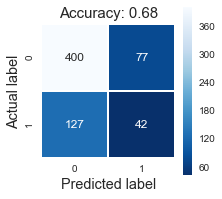

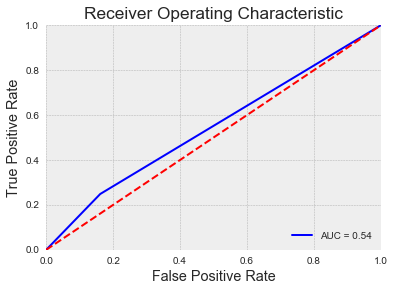

In [25]:
#Apply parameters from GridSearch
SVC_sparse = SVC(random_state=42,
               C = 5.0, 
               kernel = 'linear')

SVC_sparse.fit(sparse_train, y_train)

SVC_title_text_predictions = SVC_sparse.predict(sparse_test)

model_report("SVC (using title and text field only)",y_test, SVC_title_text_predictions)

## B. Apply Same Model only to Text Field

In [44]:
no_features = 1000

#Create a sparse matrix for the text
sparse_maker_text = Pipeline([('vect', CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, 
                                                       ngram_range  = (1, 1))),
                      ('tfidf', TfidfTransformer(use_idf = False)),])

sparse_train_text_only = coo_matrix(sparse_maker_text.fit_transform(word_clean(x_train['request_text_edit_aware'].tolist())))

sparse_test_text_only  = coo_matrix(sparse_maker_text.transform(word_clean(x_test['request_text_edit_aware'].tolist())))

SVC (using title and text field only)
---------
             precision    recall  f1-score   support

      False       0.76      0.84      0.80       477
       True       0.35      0.25      0.29       169

avg / total       0.65      0.68      0.66       646



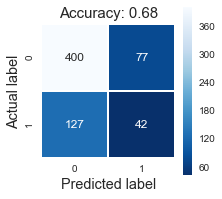

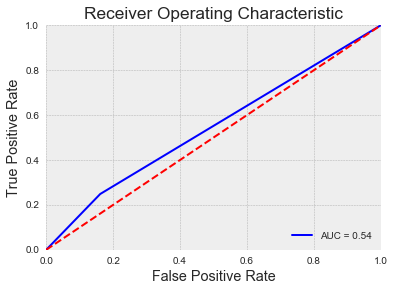

In [30]:
#Apply parameters from GridSearch
SVC_sparse_text_only = SVC(random_state=42,
               C = 5.0, 
               kernel = 'linear')

SVC_sparse_text_only.fit(sparse_train_text_only, y_train)

SVC_text_predictions = SVC_sparse_text_only.predict(sparse_test_text_only)

model_report("SVC (using title and text field only)",y_test, SVC_title_text_predictions)

## C. Conduct Topic Analysis (as seen online)

In [69]:
#source: https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(word_clean(x_train['request_text_edit_aware'].tolist()))
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(word_clean(x_train['request_text_edit_aware'].tolist()))
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', 
                                learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
print("NMF Topics:")
display_topics(nmf, tfidf_feature_names, no_top_words)
print("LDA Topics:")
display_topics(lda, tf_feature_names, no_top_words)

NMF Topics:
Topic 0:
help work ve time eat week year live thing home
Topic 1:
pizza right hut random love good ll order tonight act
Topic 2:
http com imgur jpg www pic reddit png picture proof
Topic 3:
hungry broke im sob super story eat help dont say
Topic 4:
pay friday week forward rent promise favor ll help ramen
Topic 5:
food money house days stamp right today eat month fridge
Topic 6:
student college poor break final loan study kid class meal
Topic 7:
job new lose month interview rent start live end celebrate
Topic 8:
day today eat lunch work couple car birthday sick home
Topic 9:
thanks tonight hey im help advance hi low cash tomorrow
LDA Topics:
Topic 0:
meat expense haha song clear thing feeling unexpected doesnt record
Topic 1:
story pizza sob sister mom home college title hospital game
Topic 2:
birthday study final anybody pizza test appreciated code cheer paint
Topic 3:
pizza domino hut delivery papa butter cheese appreciate hungry place
Topic 4:
campus yup uh huh human eati

# VIII. Combine Topic Analysis and Numeric Fields

### A. MNF

In [70]:
#Apply NMF Transformation

#train
nmf_train = nmf.transform(tfidf)
nmf_train2 = np.hstack((x_trainLR,nmf_train))

#test
tfidf_test = tfidf_vectorizer.transform(word_clean(x_test['request_text_edit_aware'].tolist()))
nmf_test = nmf.transform(tfidf_test)
nmf_test2 = np.hstack((x_testLR,nmf_test))

Logistic Regression (using only common numeric fields)
---------
             precision    recall  f1-score   support

      False       0.76      0.95      0.85       478
       True       0.53      0.17      0.26       168

avg / total       0.70      0.74      0.69       646



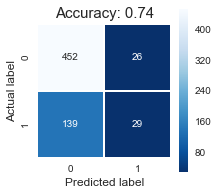

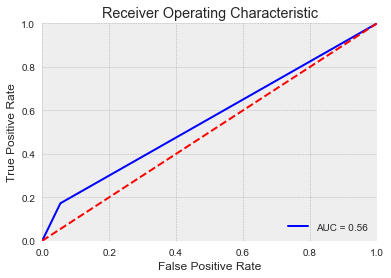

In [73]:
tpot_pipeline = make_pipeline(
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.001, max_depth=8, 
                                                           max_features=0.85, 
                                                           min_samples_leaf=11, 
                                                           min_samples_split=8, 
                                                           n_estimators=100,
                                                           subsample=0.1)),
    LogisticRegression(C=100.0, dual=False, penalty="l2")
)

tpot_pipeline.fit(nmf_train2, y_train)
predictions = tpot_pipeline.predict(nmf_test2)

#Output model report
model_report("Logistic Regression (using only common numeric fields)",y_test, predictions)

In [59]:
from tpot import TPOTClassifier


tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, scoring = "roc_auc")
tpot.fit(nmf_train2, y_train)
print(tpot.score(nmf_test2, y_test))
tpot.export('tpot_pipelineall.py')

C:\Users\zmerritt\AppData\Local\Continuum\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Generation 1 - Current best internal CV score: 0.6743480658020491


Generation 2 - Current best internal CV score: 0.6743480658020491


Generation 3 - Current best internal CV score: 0.6743480658020491


Generation 4 - Current best internal CV score: 0.6774082846548743


Generation 5 - Current best internal CV score: 0.6774082846548743



Best pipeline: RandomForestClassifier(OneHotEncoder(input_matrix, minimum_fraction=0.05, sparse=False), bootstrap=True, criterion=entropy, max_features=0.2, min_samples_leaf=13, min_samples_split=5, n_estimators=100)
0.701028370114


True

Logistic Regression (using only common numeric fields)
---------
             precision    recall  f1-score   support

      False       0.75      0.99      0.86       477
       True       0.79      0.09      0.16       169

avg / total       0.76      0.76      0.67       646



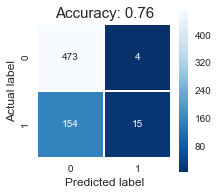

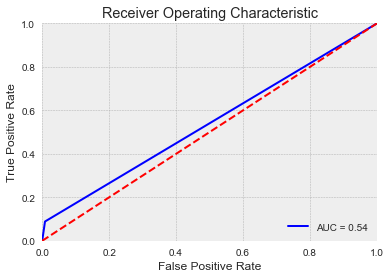

In [66]:
predictions = tpot.predict(nmf_test2)

#Output model report
model_report("Logistic Regression (using only common numeric fields)",y_test, predictions)

Logistic Regression (using only common numeric fields)
---------
             precision    recall  f1-score   support

      False       0.75      0.98      0.85       478
       True       0.62      0.08      0.14       168

avg / total       0.72      0.75      0.67       646



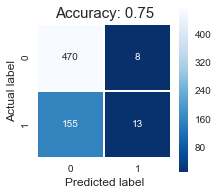

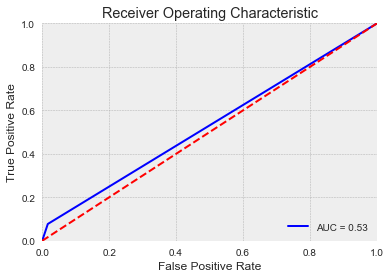

In [72]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from tpot.builtins import OneHotEncoder


# Score on the training set was:0.6774082846548743
exported_pipeline = make_pipeline(
    OneHotEncoder(minimum_fraction=0.05, sparse=False),
    RandomForestClassifier(bootstrap=True, criterion="entropy", 
                           max_features=0.2, min_samples_leaf=13, min_samples_split=5, n_estimators=100)
)

exported_pipeline.fit(nmf_train2, y_train)
predictions = exported_pipeline.predict(nmf_test2)

#Output model report
model_report("Logistic Regression (using only common numeric fields)",y_test, predictions)

### B. LDA

In [51]:
#Apply LDA Transformation

#train
lda_train = lda.transform(tf)
lda_train2 = np.hstack((x_trainLR,nmf_train))

#test
tf_test = tf_vectorizer.transform(word_clean(x_test['request_text_edit_aware'].tolist()))
lda_test = lda.transform(tf_test)
lda_test2 = np.hstack((x_testLR,lda_test))

Logistic Regression (using only common numeric fields)
---------
             precision    recall  f1-score   support

      False       0.77      0.77      0.77       477
       True       0.36      0.37      0.36       169

avg / total       0.67      0.67      0.67       646



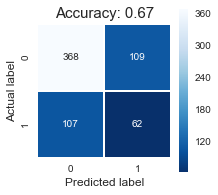

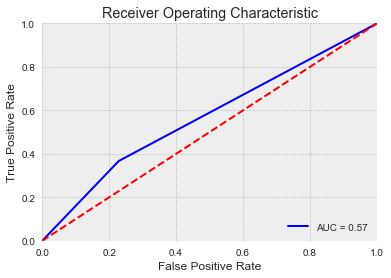

In [52]:
tpot_pipeline_lda = make_pipeline(
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.001, max_depth=8, 
                                                           max_features=0.85, 
                                                           min_samples_leaf=11, 
                                                           min_samples_split=8, 
                                                           n_estimators=100,
                                                           subsample=0.1)),
    LogisticRegression(C=100.0, dual=False, penalty="l2")
)

tpot_pipeline_lda.fit(lda_train2, y_train)
predictions = tpot_pipeline_lda.predict(lda_test2)

#Output model report
model_report("Logistic Regression (using only common numeric fields)",y_test, predictions)

# XI. Feature Engineering

### A. Add count field for topics

In [179]:
def requester_subreddits_at_request_counter(data):
    """
    Create dummy variables for the field: requester_subreddits_at_request
    """
    requester_subreddits_at_request2 = []
    lookup = data['requester_subreddits_at_request'].tolist()
    for i in range(len(lookup)):
        requester_subreddits_at_request2 += lookup[i]
    uniqueWords = [] 
    for i in requester_subreddits_at_request2:
        if not i in uniqueWords:
            uniqueWords.append(i)
    for i in range(len(lookup)):
        for a in range(len(uniqueWords)):
            word = requester_subreddits_at_request2[i]
            data[word] = uniqueWords[a] in lookup[i]
    return(data)

In [227]:
def requester_days_since_first_post_on_raop_at_request_greater_than_one(data):
        x = np.array(data[('requester_days_since_first_post_on_raop_at_request')] > 1)
        data.loc[:,('requester_days_since_first_post_on_raop_at_request_greater_than_one')] = x
        return(data)